# General Overview - Statistical Analysis

- Are there variables that are particularly significant in terms of explaining the answer to your project question?
- Are there significant differences between subgroups in your data that may be relevant to your project aim?
- Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
- What are the most appropriate tests to use to analyze these relationships?

Use chi square test for categorical variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
data = pd.read_csv('tree_census_stat_ready.csv', index_col=0, encoding='utf-8') # import data
tree = data.copy() # save a copy of data as tree

In [3]:
# sample of dataset

tree.head(10)

,tree_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,problems,root_stone,...,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,longitude,latitude,num_problems
0,180683,3,OnCurb,Fair,red maple,None,None,NoDamage,None,No,...,No,No,No,No,No,No,Queens,-73.844215,40.723092,0
1,200540,21,OnCurb,Fair,pin oak,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Queens,-73.818679,40.794111,1
2,204026,3,OnCurb,Good,honeylocust,1or2,None,Damage,None,No,...,No,No,No,No,No,No,Brooklyn,-73.936608,40.717581,0
3,204337,10,OnCurb,Good,honeylocust,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.934456,40.713537,1
4,189565,21,OnCurb,Good,American linden,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.975979,40.666778,1
5,190422,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,None,No,...,No,No,No,No,No,No,Manhattan,-73.984950,40.770046,0
6,190426,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,None,No,...,No,No,No,No,No,No,Manhattan,-73.985338,40.770210,0
7,208649,9,OnCurb,Good,American linden,None,None,NoDamage,MetalGrates,No,...,No,No,No,No,No,No,Manhattan,-73.987297,40.762724,1
8,209610,6,OnCurb,Good,honeylocust,None,None,NoDamage,None,No,...,No,No,No,No,No,No,Staten Island,-74.076255,40.596579,0
9,192755,21,OffsetFromCurb,Fair,London planetree,None,None,NoDamage,None,No,...,No,No,No,No,No,No,Brooklyn,-73.969744,40.586357,0


The problems column is reflected in the adjacent 9 columns so we are removing it from our dataset along with longitude and latitude since they are used to map the location of the trees. We do not need the latitude and longitude columns either since they are used to map the location of the tree, see data storytelling for the maps. Finally, we are removing tree_id since the trees are identified using their index number.

In [4]:
col_remove = ['tree_id', 'problems', 'longitude', 'latitude'] # columns to remove

tree = tree.drop(col_remove, axis=1)

In [5]:
tree.head(10)

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,num_problems
0,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Queens,0
1,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Queens,1
2,3,OnCurb,Good,honeylocust,1or2,None,Damage,No,No,No,No,No,No,No,No,No,Brooklyn,0
3,10,OnCurb,Good,honeylocust,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1
4,21,OnCurb,Good,American linden,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1
5,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,No,No,No,No,No,No,No,No,No,Manhattan,0
6,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,No,No,No,No,No,No,No,No,No,Manhattan,0
7,9,OnCurb,Good,American linden,None,None,NoDamage,No,Yes,No,No,No,No,No,No,No,Manhattan,1
8,6,OnCurb,Good,honeylocust,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Staten Island,0
9,21,OffsetFromCurb,Fair,London planetree,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Brooklyn,0


## Analyzing Diameter Distributions

Most of our data consists of categorical variables, only two columns, tree_dbh and num_problems, consist of numerical variables. Longitude and latitude are useful for plotting and they are floats. Let's take a look at the distribution of tree_dbh, tree diameters in inches.

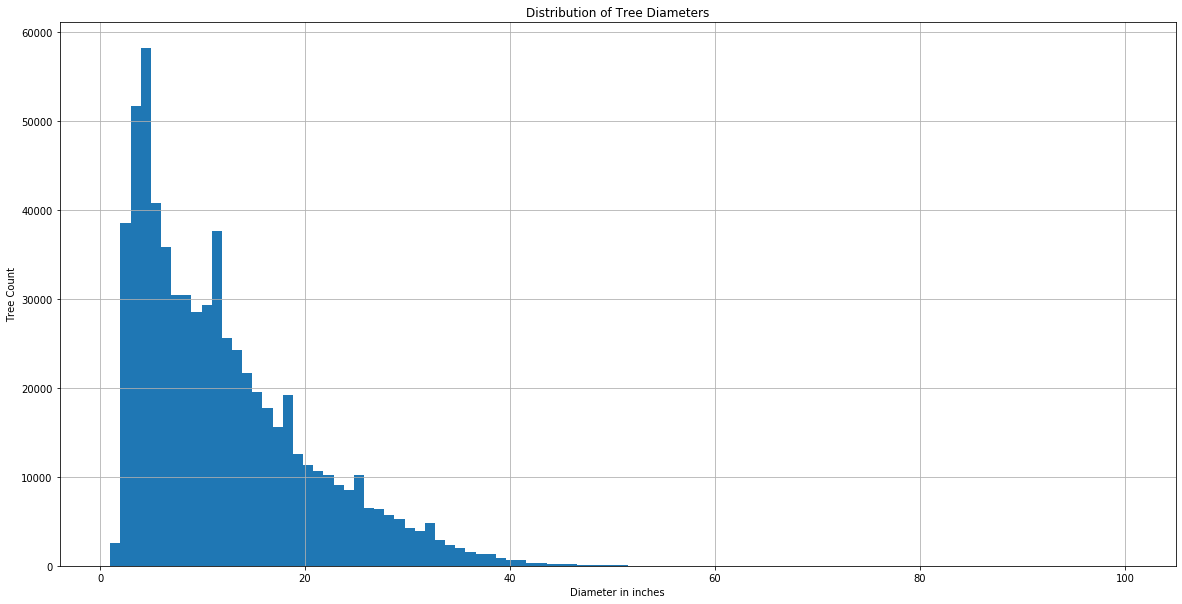

In [6]:
plt.figure(figsize=(20, 10))
tree.tree_dbh.hist(bins=100)
plt.xlabel('Diameter in inches')
plt.ylabel('Tree Count')
plt.title('Distribution of Tree Diameters')
plt.show()

The distribution of diameters is heavily skewed to the right and it looks like there are very few trees with diameters greater than 50 inches.

In [7]:
tree[tree.tree_dbh > 50].shape # number of trees with diameters greater than 50 inches

(294, 18)

Since only 294 trees have diameters greater than 50 inches, we will remove them from the dataset in order to better represent the majority of trees.

In [8]:
tree = tree[tree.tree_dbh < 51] # remove trees with diameters greater than 50 inches

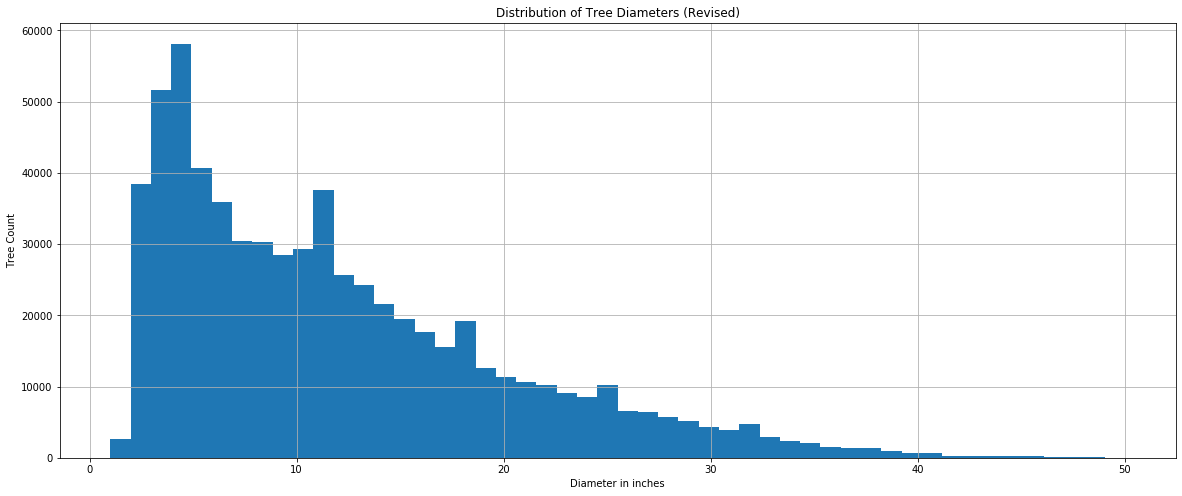

In [9]:
plt.figure(figsize=(20, 8))
tree.tree_dbh.hist(bins=50)
plt.xlabel('Diameter in inches')
plt.ylabel('Tree Count')
plt.title('Distribution of Tree Diameters (Revised)')
plt.show()

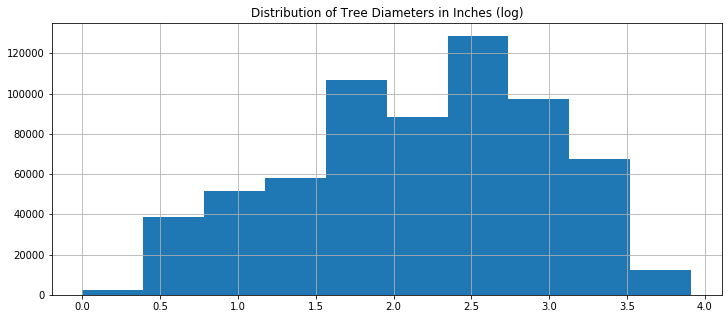

In [10]:
# take the log of tree_dbh

dbh_log = np.log(tree.tree_dbh)

plt.figure(figsize=(12, 5))
dbh_log.hist()
plt.title('Distribution of Tree Diameters in Inches (log)')
plt.show() # the distribution appears closer to normal after taking the log

Taking the log of the diameters, the distribution is slightly skewed to the left but is closer to a normal distribution than previously.

Since we want to locate the true mean, we will calculate the 95% confidence interval.

In [11]:
# isolate diameters

diam = tree.tree_dbh

# 95% confidence interval, z score = 1.96

margin = (1.96 * np.std(diam)) / np.sqrt(len(diam))

lower = np.mean(diam) - margin
upper = np.mean(diam) + margin

print('Mean Value: ', np.mean(diam))
print('Lower Interval: ', lower)
print('Upper Interval: ', upper)

Mean Value:  11.674665213687677
Lower Interval:  11.65435006469371
Upper Interval:  11.694980362681642


In [12]:
np.percentile(diam, [2.5, 97.5]) # 95% of values are between 2 and 32

array([ 2., 32.])

## Encoding Categorical Data

### root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

Since these columns contain Yes or No answers, we can convert them to 0 or 1 with 0 being No and 1 being Yes. We will use the one-hot encoding scheme.

In [14]:
# root_stone
# tree['root_stone_label'] = tree.root_stone.replace(to_replace=['No', 'Yes'], value=[0,1])
# tree.head()

In [15]:
# transform and map root_stone

rs_le = LabelEncoder()
rs_labels = rs_le.fit_transform(tree.root_stone)
tree['root_stone_labels'] = rs_labels

In [19]:
# function to transform and map remaining columns

cols_transform = ['root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

for x in cols_transform:
    tree[x + '_labels'] = LabelEncoder().fit_transform(tree[x])

In [33]:
# view results - part

tree[['root_stone', 'root_stone_labels', 'root_grate', 'root_grate_labels', 'root_other', 'root_other_labels', 'trunk_wire', 'trunk_wire_labels', 'trnk_light', 'trnk_light_labels']].head()

,root_stone,root_stone_labels,root_grate,root_grate_labels,root_other,root_other_labels,trunk_wire,trunk_wire_labels,trnk_light,trnk_light_labels
0,No,0,No,0,No,0,No,0,No,0
1,Yes,1,No,0,No,0,No,0,No,0
2,No,0,No,0,No,0,No,0,No,0
3,Yes,1,No,0,No,0,No,0,No,0
4,Yes,1,No,0,No,0,No,0,No,0


In [34]:
# overall view

tree.head(10)

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,...,num_problems,root_stone_labels,root_grate_labels,root_other_labels,trunk_wire_labels,trnk_light_labels,trnk_other_labels,brch_light_labels,brch_shoe_labels,brch_other_labels
0,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,...,0,0,0,0,0,0,0,0,0,0
1,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,...,1,1,0,0,0,0,0,0,0,0
2,3,OnCurb,Good,honeylocust,1or2,None,Damage,No,No,No,...,0,0,0,0,0,0,0,0,0,0
3,10,OnCurb,Good,honeylocust,None,None,Damage,Yes,No,No,...,1,1,0,0,0,0,0,0,0,0
4,21,OnCurb,Good,American linden,None,None,Damage,Yes,No,No,...,1,1,0,0,0,0,0,0,0,0
5,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,No,No,No,...,0,0,0,0,0,0,0,0,0,0
6,11,OnCurb,Good,honeylocust,1or2,Helpful,NoDamage,No,No,No,...,0,0,0,0,0,0,0,0,0,0
7,9,OnCurb,Good,American linden,None,None,NoDamage,No,Yes,No,...,1,0,1,0,0,0,0,0,0,0
8,6,OnCurb,Good,honeylocust,None,None,NoDamage,No,No,No,...,0,0,0,0,0,0,0,0,0,0
9,21,OffsetFromCurb,Fair,London planetree,None,None,NoDamage,No,No,No,...,0,0,0,0,0,0,0,0,0,0


The next part involves creating new columns for each answer option.

### Stewardships and Tree Health

Let's see if there is a relationship between stewardship and tree health using the chi square test. Our null hypothesis states that there is no relationship (i.e. correlation) between the health of a tree and tree stewardship.

In [13]:
# one-hot encoding scheme

